<a href="https://colab.research.google.com/github/kunalprakash1309/Introduction-to-Statistical-Learning-using-Python/blob/main/Ch_4_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install ISLP

# Predict the future market performance using GLM, LDA, QDA, GaussianNB, KNeighorsClassifier

Dataset : Daily percentage returns for the S&P 500 stock index between 2001 and 2005.

Features :     

* `Year`: The year that the observation was recorded
* `Lag1`: Percentage return for previous day
* `Lag2`: Percentage return for 2 days previous
* `Lag3`: Percentage return for 3 days previous
* `Lag4`: Percentage return for 4 days previous
* `Lag5`: Percentage return for 5 days previous
* `Volume`: Volume of shares traded (number of daily shares traded in billions)
* `Today`: Percentage return for today
* `Direction`: A factor with levels 'Down' and 'Up' indicating whether the market had a positive or negative return on a given day

### Aim : Which model will have more accuracy?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

In [3]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Import Data

In [4]:
df = load_data('Smarket')
df

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1250 non-null   int64  
 1   Lag1       1250 non-null   float64
 2   Lag2       1250 non-null   float64
 3   Lag3       1250 non-null   float64
 4   Lag4       1250 non-null   float64
 5   Lag5       1250 non-null   float64
 6   Volume     1250 non-null   float64
 7   Today      1250 non-null   float64
 8   Direction  1250 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 88.0+ KB


In [6]:
df.isna().sum()

Year         0
Lag1         0
Lag2         0
Lag3         0
Lag4         0
Lag5         0
Volume       0
Today        0
Direction    0
dtype: int64

In [7]:
df.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [8]:
df.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


Counts of Market Direction

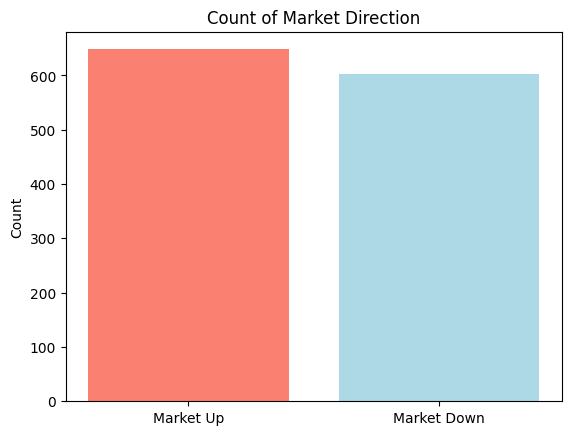

In [71]:
fig, ax = plt.subplots()

up_count = df['Direction'].value_counts()[0]
down_count = df['Direction'].value_counts()[1]

x_label = ['Market Up', 'Market Down']
y_label = [up_count, down_count]
ax.bar(x_label, y_label, color=['salmon', 'lightblue'])
ax.set_title("Count of Market Direction")
ax.set_ylabel("Count");

### Correlation Matrix

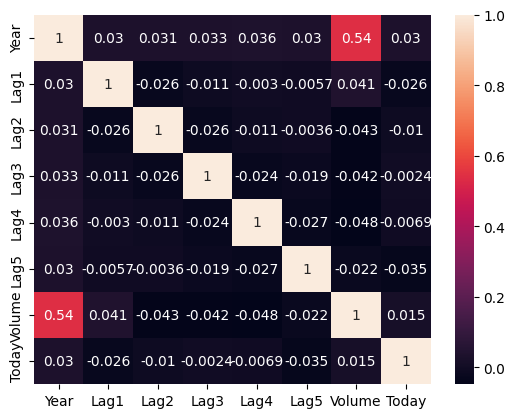

In [9]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True);

**Inference : No significant value in correlation matrix except between Year and Volume**

Let us check the relation between Year and Volume feature by drawing graph

<Axes: >

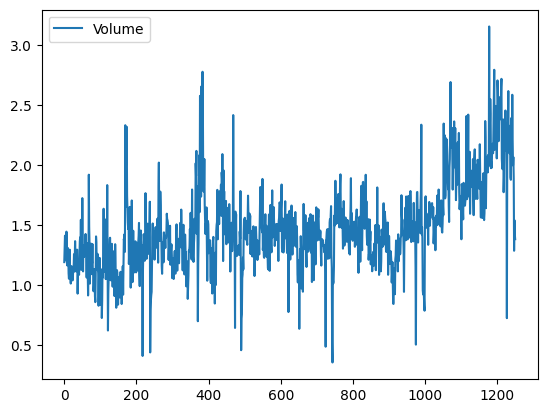

In [11]:
df.plot(y='Volume')

**Inference : We can see the Volume is increasing over time**

## Logistic Regression

We will use `sm.GLM()` function to fit generalized linear models. It takes various form of families as input. `family=sm.families.Gaussian` for linear regression and `family=sm.families.Binomial` for logistic regression.

Here we will use `family=sm.families.Binomial`.

In [12]:
allvars = df.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)

X = design.fit_transform(df)
y = df.Direction == 'Up'
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


**Inference** :
  * **The smallest `p-value` is associated with `Lag1`**
  * **The negative coeffecient of for `Lag1` suggests that if it has a positive return yesterday then it is likely to go up today.**
  * **However the value of `p` is `0.145` which is relatively large, and so there is no clear evidence of a real relation between `Lag1` and `Direction`.**

In [13]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [14]:
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [15]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [16]:
# create an list of Down and Up respective of results.predict()
labels = np.array(['Down']*1250)
labels[probs > 0.5] = 'Up'

In [17]:
confusion_table(labels, df['Direction'])

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


Diagonal elements indicate correct predictions while the anti-diagonal indicate incorrect predictions.

**Inference** :     
* **Our model correctly predicted that the market would go up on 507 days and that it would go down on 145 days.**
* **Total of 507 + 145 = 652 correct predictions**.

In [18]:
(507+145)/1250 , np.mean(labels == df['Direction'])

(0.5216, 0.5216)

**Inference : Accuracy for general linearized model(GLM) is 52.16%(on training set)**

## Create Train and Test
Above we train and test our model on same set. It tends to underestimate the test error rate.

To yeild a more realistic error rate. We test our model on other set than training set.

Training set will consist of stock which range form year 2001 to 2004. Test set will consist of stock of year 2005

In [19]:
train = (df['Year'] < 2005)
df_train = df.loc[train]
df_test = df.loc[~train]
df_train.shape, df_test.shape

((998, 9), (252, 9))

In [20]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

Fit the training data into GLM model

In [21]:
glm_train = sm.GLM(y_train, X_train, family= sm.families.Binomial())
results1 = glm_train.fit()
summarize(results1)

,coef,std err,z,P>|z|
intercept,0.1912,0.334,0.573,0.567
Lag1,-0.0542,0.052,-1.046,0.295
Lag2,-0.0458,0.052,-0.884,0.377
Lag3,0.0072,0.052,0.139,0.889
Lag4,0.0064,0.052,0.125,0.901
Lag5,-0.0042,0.051,-0.083,0.934
Volume,-0.1163,0.240,-0.485,0.628


In [22]:
# Predict the market direction on test data
probs1 = results1.predict(exog=X_test)
probs1

998     0.528220
999     0.515669
1000    0.522652
1001    0.513854
1002    0.498334
          ...   
1245    0.483637
1246    0.506048
1247    0.516658
1248    0.516124
1249    0.508072
Length: 252, dtype: float64

In [23]:
labels1 = probs1.apply(lambda x: "Up" if x > 0.5 else 'Down')
L_train, L_test = df.loc[train], df.loc[~train]
confusion_table(labels1, L_test['Direction'])

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [24]:
np.mean(labels1 == L_test['Direction']), np.mean(labels1 != L_test['Direction'])

(0.4801587301587302, 0.5198412698412699)

**Inference : The test accuracy is about 48% and error rate is about 52%**

## Remove some of the feature from training model
As we have seen from corelation matrix that Lag1 and Lag2 are more significant.
Hence remove the rest of the feature. Now all the below model will only consist of Lag1 and Lag2

In [25]:
model2 = MS(['Lag1', 'Lag2']).fit(df)
X = model2.transform(df)
X

,intercept,Lag1,Lag2
0,1.0,0.381,-0.192
1,1.0,0.959,0.381
2,1.0,1.032,0.959
3,1.0,-0.623,1.032
4,1.0,0.614,-0.623
...,...,...,...
1245,1.0,0.422,0.252
1246,1.0,0.043,0.422
1247,1.0,-0.955,0.043
1248,1.0,0.130,-0.955


# Generalized Linear Model

In [26]:
# Fit the data

X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())

results2 = glm_train.fit()
summarize(results2)

,coef,std err,z,P>|z|
intercept,0.0322,0.063,0.508,0.611
Lag1,-0.0556,0.052,-1.076,0.282
Lag2,-0.0445,0.052,-0.861,0.389


In [27]:
# predict the market direction on test data

probs2 = results2.predict(exog=X_test)
probs2

998     0.509827
999     0.520824
1000    0.533263
1001    0.526057
1002    0.507210
          ...   
1245    0.499384
1246    0.502763
1247    0.520844
1248    0.516862
1249    0.510751
Length: 252, dtype: float64

In [28]:
labels2 = probs2.apply(lambda x: 'Up' if x > 0.5 else 'Down')
confusion_table(labels2, L_test['Direction'])

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [29]:
np.mean(labels2 == L_test['Direction'])

0.5595238095238095

In [30]:
(106+35)/252, 106/(106+76)

(0.5595238095238095, 0.5824175824175825)

**Inference** :    
* **Test accuracy = 56% => 56% of the daily movements have been correctly predicted**
* **Days when logistic regression predicts an increase in the market, it has accuracy rate = 58%**

**This suggest that a possible trading strategy of buying on days when the model predicts an increasing market and avoiding trades on days when a decrease is predicted.**

Suppose we want to predict the returns associated with particular values of `Lag1` and `Lag2`.

In [31]:
newdata = pd.DataFrame({'Lag1': [1.2, 1.5],
                        'Lag2': [1.1, -0.8]})
newX = model2.transform(newdata)
newX

,intercept,Lag1,Lag2
0,1.0,1.2,1.1
1,1.0,1.5,-0.8


In [32]:
results2.predict(newX)

0    0.479146
1    0.496094
dtype: float64

# Linear Discriminant Analysis

In [33]:
lda = LDA(store_covariance=True)

In [34]:
# remove intercept column because scikit will automatically add the intercepet.
X_train, X_test = X_train.drop('intercept', axis=1), X_test.drop('intercept', axis=1)

In [35]:
lda.fit(X_train, L_train['Direction'])

LinearDiscriminantAnalysis(store_covariance=True)

In [36]:
lda.coef_

array([[-0.05544078, -0.0443452 ]])

In [37]:
lda.covariance_

array([[ 1.50886781, -0.03340234],
       [-0.03340234,  1.5095363 ]])

In [38]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [39]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [40]:
lda.priors_

array([0.49198397, 0.50801603])

In [41]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [42]:
# Predict the market direction on test data
lda_predict = lda.predict(X_test)

In [43]:
confusion_table(lda_predict, L_test['Direction'])

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [73]:
lda_prob = lda.predict_proba(X_test)
lda_prob[:4]

array([[0.49017925, 0.50982075],
       [0.4792185 , 0.5207815 ],
       [0.46681848, 0.53318152],
       [0.47400107, 0.52599893]])

In [45]:
np.all(np.where(lda_prob[:, 1] >= 0.5, 'Up', 'Down') == lda_predict)

True

In [75]:
np.mean(lda_predict == L_test['Direction'])

0.5595238095238095

**Inference : Test accuracy is about 56%**

## Quadratic Discriminant Analysis

We will now fit a QDA model to the Smarket data.

In [76]:
# Fit the model
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train['Direction'])

QuadraticDiscriminantAnalysis(store_covariance=True)

In [47]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [48]:
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [49]:
# Predict the market direction on test data
qda_predict = qda.predict(X_test)
confusion_table(qda_predict, L_test['Direction'])

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [50]:
np.mean(qda_predict==L_test['Direction'])

0.5992063492063492

**Inference : Test accuracy is about 60%**

## Naive Bayes

In [51]:
# Fit the model
NB = GaussianNB()
NB.fit(X_train, L_train['Direction'])

GaussianNB()

In [52]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [53]:
NB.class_count_, NB.class_prior_

(array([491., 507.]), array([0.49198397, 0.50801603]))

In [54]:
NB.feature_names_in_

array(['Lag1', 'Lag2'], dtype=object)

In [55]:
NB.theta_ # => mean of each feature per class

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

mean of feature `Lag1` is 0.042

In [56]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

We can also calculate the mean this way

In [57]:
X_train[L_train['Direction'] == 'Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

In [58]:
# Predict the model
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test['Direction'])

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [59]:
150/(150+82+20)

0.5952380952380952

In [60]:
np.mean(nb_labels==L_test['Direction'])

0.5952380952380952

**Inference : Test Accuracy is about 59.5%**


## K-Nearest Neighbors

In [77]:
# Fit the model with n_neighbors = 1
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train['Direction'])
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test['Direction'])

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [62]:
np.mean(knn1_pred == L_test['Direction'])

0.5

Using K = 3

In [63]:
# Fit the model with n_neighbors = 3
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, L_train['Direction'])
knn3_pred = knn3.predict(X_test)
confusion_table(knn3_pred, L_test['Direction'])

Truth,Down,Up
Predicted,,
Down,48,55
Up,63,86


In [64]:
np.mean(knn3_pred == L_test['Direction'])

0.5317460317460317

**Inference** :
* **Test accuracy for `n_neighbors=1` is 50%**.
* **Test accuracy for `n_neighbors=3` is 53%** .

# Outcome

Test accuracy of different models with two feature variable (`Lag1` and `Lag2`)
* Generalized Linear Model => 56%
* Linear Discriminant Analysis => 56%
* Quadratic Discriminant Analysis => 60%
* Naive Bayes => 59.5%
* K-Nearest Neighbors
  * for n_neighbors = 1 => 50%
  * for n_neighbors = 3 => 53%

**Hence, QDA and Naive Bayes ar the most well performed model for this dataset.**

** Note - 60% accuracy is also not a desired accuracy. This result is not surprising, given that one would not generally expect to be able use previoius days return to predict the future market performance. If it possible anyone with these knowledge became a millionare.